In [5]:
import json

In [6]:


experiments_path = "../"

def fc_to_string(k,cfg):
    res = f"k_{k}bits_"
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    res +=  "logsize_"
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res


def bits_str(cfg):
    res = "b."
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    return res

def bits_valid(cfg):
    for layer in cfg:
        if layer["bits"] > 128:
            return False
    
    return True

def logsize_str(cfg):
    res = "sz."
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res
  
def load_configs(name):
    with open(f'{experiments_path}config_{name}', 'r') as myfile:
        data=myfile.read()
        obj = json.loads(data)
        return obj["config"]  

def load_exp(fn):
    try:
        with open(fn, 'r') as myfile:
            data=myfile.read()
            # print(data)
            obj = json.loads(data)
            return obj
    except Exception as err:
        print(err)
        return None

    
datasets =[
           ("Twitter 100 mio","twitter_100mio_coords.h5"),
           ("Twitter 200 mio","twitter_200mio_coords.h5"),
           ("Asia 200 mio","asia_200mio_coords.h5"),
           ("Asia 500 mio","asia_500mio_coords.h5")         
          
          ]

In [7]:
k = 8;
x = 0;
width = 1 * 8192
height = 1 * 8192;
exp_name = "test_datasets_for_k";


cfgs = load_configs(exp_name)

5 6
{'b.1.8.': 0, 'b.1.16.': 1, 'b.1.32.': 2, 'b.8.16.': 3, 'b.8.32.': 4}
{'sz.16.20.': 0, 'sz.16.24.': 1, 'sz.20.16.': 2, 'sz.20.24.': 3, 'sz.24.16.': 4, 'sz.24.20.': 5}


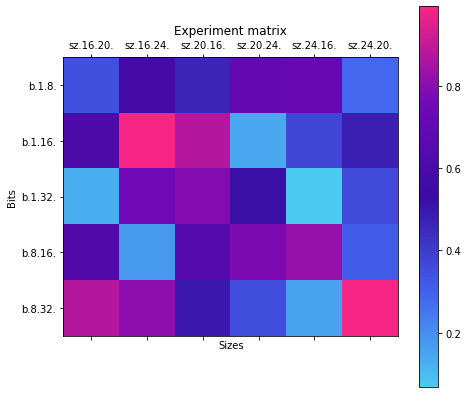

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.backends.backend_pdf as pdf
import tqdm
import matplotlib
colors = ["#F72585","#7209B7", "#3A0CA3","#4361EE", "#4CC9F0"]
colors.reverse()
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("neodym",[matplotlib.colors.to_rgb(x) for x in colors])
colors = ["#F72585", "#3A0CA3", "#4CC9F0"]

def save_figs(fn):
    print(f"-->  Saving all figures... {fn}")
    out_pdf = pdf.PdfPages(fn)
    for fig in tqdm.tqdm(range(1, plt.gcf().number+1)):
        out_pdf.savefig( fig )
    out_pdf.close()
    plt.close("all")


def plot_matrix(cm, title='Experiment matrix', cmap=colormap, xlabels=None, ylabels=None, cblabel=None):
    fig = plt.figure(figsize=(len(xlabels)*1.25, 2+ len(ylabels)))
    ax = fig.add_subplot(111)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    cax = ax.matshow(cm,cmap=cmap)
    plt.title(title)
    ax.set_xticks(range(len(xlabels)))
    ax.set_yticks(range(len(ylabels)))
    cbar = fig.colorbar(cax)

    if cblabel:
        cbar.set_label(cblabel)
    if xlabels:
        ax.set_xticklabels(list(xlabels))
    if ylabels:
        ax.set_yticklabels(list(ylabels))
    plt.xlabel('Sizes')
    plt.ylabel('Bits')
    #plt.show()



def make_maps(size, cfgs):
    bits_map = {}
    logsize_map = {}

    count_bits =0
    count_sizes = 0
    for c in cfgs :

        if len(c) ==size and bits_valid(c):
            if(not bits_str(c) in bits_map):
                bits_map[bits_str(c)] = count_bits
                count_bits+=1
            if(not logsize_str(c) in logsize_map):
                logsize_map[logsize_str(c)] = count_sizes
                count_sizes+=1
    return bits_map, logsize_map

def make_maps_any( cfgs):
    bits_map = {}
    logsize_map = {}

    count_bits =0
    count_sizes = 0
    for c in cfgs :

        if bits_valid(c):
            if(not bits_str(c) in bits_map):
                bits_map[bits_str(c)] = count_bits
                count_bits+=1
            if(not logsize_str(c) in logsize_map):
                logsize_map[logsize_str(c)] = count_sizes
                count_sizes+=1
    return bits_map, logsize_map

bits_map, logsize_map = make_maps(2,cfgs)

print(len(bits_map), len(logsize_map))
print(bits_map)
print(logsize_map)
a = np.random.rand(len(bits_map), len(logsize_map))
plot_matrix(a, ylabels=bits_map.keys(), xlabels=logsize_map.keys())


In [8]:
figsize=(6,6)
def plot_some(cm, title='Experiment', xlabels=None, ylabels=None, cblabel=None, K=range(1,30)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    # print(xlabels)
    # print(ylabels)
    sz = 1

    lines = ['-', '--', '-.', ':']
    i = 0
    for x in range(0,len(xlabels)):
        for y in range(0,len(ylabels)):
            # print(x,y)
            vals = []
            for k in K:
                vals.append( cm[k][y,x])
            plt.plot(list(K), vals, label=f'{ylabels[y]}{xlabels[x]}', linewidth=sz, linestyle=lines[i%len(lines)], c= colormap(i/(len(xlabels)*len(ylabels))))
            i += 1
            sz += 0.5
    plt.legend()
    plt.title(title)

    #plt.show()

def make_matrices(size, cfgs):
    bits_map, logsize_map = make_maps(size,cfgs)
    # print(bits_map)
    matrices= {}
    matrix_indices = ["error_rate"]
    

    for dn, ds in datasets :
        matrices[ds] = {}
        for mi in matrix_indices:
            matrices[ds][mi] ={}

            for k in range(1,30):
                matrices[ds][mi][k] =  np.zeros((len(bits_map),(len(logsize_map))))-1
            matrices[ds][mi]["best_k"] =  np.zeros((len(bits_map),(len(logsize_map))))-1
            matrices[ds][mi]["val"] = np.zeros((len(bits_map),(len(logsize_map))))+1000



    x=0
    for k in range(1,30):
        for c in cfgs :
            # print(fc_to_string(k,c))
            y = 0;
            for  dn, ds in datasets :
                fn = experiments_path + exp_name + "/" + exp_name + f'.w{width}h{height}.{x:04d}-' + fc_to_string(k,c) \
                + ds + ".json"
                data = load_exp(fn)
                bits = bits_str(c)
                sz = logsize_str(c)
                if data and bits in bits_map and  sz in logsize_map and bits_valid(c):
                    for mi in matrix_indices:
                        v = matrices[ds][mi]["val"][ bits_map[bits],logsize_map[sz]]
                        matrices[ds][mi][k][ bits_map[bits],logsize_map[sz]] = data["summary"]["error_summary"][mi]
                        if  v > data["summary"]["error_summary"][mi]:
                            matrices[ds][mi]["best_k"][ bits_map[bits],logsize_map[sz]] = k
                            matrices[ds][mi]["val"][ bits_map[bits],logsize_map[sz]] = data["summary"]["error_summary"][mi]
                y+=1
            x+=1


    for  dn, ds in datasets :
        for mi in matrix_indices:   
            plot_matrix( matrices[ds][mi]["best_k"] ,title=f'{dn} {mi}',ylabels=bits_map.keys(), xlabels=logsize_map.keys(), cblabel="Best k")             
            plot_matrix( matrices[ds][mi]["val"] ,title=f'{dn} {mi}',ylabels=bits_map.keys(), xlabels=logsize_map.keys(), cblabel="Value")   
            plot_some(matrices[ds][mi],title=f'{dn} {mi}',ylabels=list(bits_map.keys()), xlabels=list(logsize_map.keys()), K=range(1,30))


make_matrices(1, cfgs)
make_matrices(2, cfgs)


save_figs("test_datasets_for_k_matrices.pdf")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


-->  Saving all figures... test_datasets_for_k_matrices.pdf


100%|██████████| 24/24 [00:01<00:00, 20.07it/s]


In [22]:
figsize=(6,6)
def make_matrices_all( cfgs):
    bits_map, logsize_map = make_maps_any(cfgs)
    # print(bits_map)
    matrices= {}
    matrix_indices = ["error_rate"]
    

    for dn, ds in datasets :
        matrices[ds] = {}
        for mi in matrix_indices:
            matrices[ds][mi] ={}

            for k in range(1,30):
                matrices[ds][mi][k] =  []



    x=0
    for k in range(1,30):
        for c in cfgs :
            # print(fc_to_string(k,c))
            y = 0;
            for  dn, ds in datasets :
                fn = experiments_path + exp_name + "/" + exp_name + f'.w{width}h{height}.{x:04d}-' + fc_to_string(k,c) \
                + ds + ".json"
                data = load_exp(fn)
                bits = bits_str(c)
                sz = logsize_str(c)
                if data and bits in bits_map and  sz in logsize_map and bits_valid(c):
                    for mi in matrix_indices:
                        matrices[ds][mi][k].append(data["summary"]["error_summary"][mi])
                y+=1
            x+=1

    vals = {}
    
    for  dn, ds in datasets :
        vals[ds] = {}
        for mi in matrix_indices: 
            vals[ds][mi] = {
                "mean": [0] * 29,
                "std": [0] * 29,
                "min": [0] * 29,
                "max": [0] * 29,
            }
            for k in range(29):            
                vals[ds][mi]["mean"][k] = np.mean(matrices[ds][mi][k+1])
                vals[ds][mi]["std"][k] = np.std(matrices[ds][mi][k+1])
                vals[ds][mi]["min"][k] = np.min(matrices[ds][mi][k+1])            
                vals[ds][mi]["max"][k] = np.max(matrices[ds][mi][k+1])
            
    
    dat = {
        "Twitter": [("Twitter 100 mio","twitter_100mio_coords.h5"),
          ("Twitter 200 mio","twitter_200mio_coords.h5")],
         "OSM":  [ ("OSM 200 mio","asia_200mio_coords.h5"),
           ("OSM 500 mio","asia_500mio_coords.h5")]
    }
    for ddn in ["Twitter", "OSM"]:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

        markers = ["o", "s", "^"]
        """
        for i in range(1,4):
            x = list(map(int, matrices[ds]["query_time"][str(i)].keys()))
            y = matrices[ds]["query_time"][str(i)].values()
            plt.scatter(x , y, label=f"{i} Layers", marker=markers[i-1], s=40)
        """
        colors = ["red", "blue", "green"]
        i = 0
        for  dn, ds in dat[ddn] :
            means = np.array(vals[ds][mi]["mean"])
            std = np.array(vals[ds][mi]["std"])
            mins = np.array(vals[ds][mi]["min"])
            maxes = np.array(vals[ds][mi]["max"])
            x = list(range(1,30))
            print(len(x), len(means))
            # create stacked errorbars:
            #plt.errorbar(x, means, std, fmt='ok', lw=3,capsize=3, label="mean +- std")
            plt.errorbar(x , means, [means - mins, maxes - means],
                         fmt='.k',ecolor= colors[i], capsize=6, lw=1, label=f"{dn} [min mean max]")
            i+= 1



        plt.legend(loc='upper left')
        plt.title(f"{ddn} k error rate")
        plt.xlabel('k')
        plt.xticks(np.arange(1,30,2))

        plt.ylabel('Error Rate') 
        

make_matrices_all( cfgs)

save_figs("test_datasets_for_k_matrices_clean.pdf")

29 29
29 29
29 29
29 29
-->  Saving all figures... test_datasets_for_k_matrices_clean.pdf


100%|██████████| 2/2 [00:00<00:00, 20.95it/s]
